# Gated Recurrent Unit
## Review
We know from RNN that we only have two parameters $W_{aa}$ and $W_{ax}$ no matter what the sequence length is. This is one of the advantages of Recurrent Neural Networks, weight sharing, that is also seen in Convolutional Neural Networks.
But the disadvantage to this unit, is vanishing/exploding gradients. Since $a^{<t>}$ is calculated with respect to $a^{<t-1>}$, in backpropagation we should back propagate it through time using chain rule. MORE ON THIS

$$
\begin{align}
    a^{<t>} &= g_1(W_{aa} a^{<t-1>} + W_{ax} x^{<t>} + b_a)\\
    \hat{y}^{<t>} &= g_2(W_{ya} a^{<t>} + b_y)
\end{align}
$$

## GRU
This new unit, introduces gates like update gate denoted as $\Gamma_u$ and reset gate that is denoted as $\Gamma_r$.
### Update Gate $\Gamma_u$
This gate controls how much of the past hidden state should be passed along to the current state. It decides how much of the previous hidden state information should be retained and how much of the new candidate information should be included.

$$
\begin{align}
    \tilde{c}^{<t>} &= g_1(W_{cc} c^{<t-1>} + W_{cx} x^{<t>} + b_c)\\
    \Gamma_u &= \sigma(W_{uu} c^{<t-1>} + W_{ux} x^{<t>} + b_u)\\
    c^{<t>} &= \Gamma_u \odot \tilde{c}^{<t>} + (1 - \Gamma_u) \odot c^{<t - 1>}\\
    \hat{y}^{<t>} &= g_2(W_{ya} c^{<t>} + b_y)
\end{align}
$$

Also GRU introduces Reset Gate.
### Reset Gate $\Gamma_r$
This gate controls how much of the past information should be forgotten or kept. It determines which parts of the past hidden state should be reset to allow new information to be incorporated into the current state.

$$
\begin{align}
    \Gamma_r &= \sigma(W_{rr} c^{<t-1>} + W_{rx} x^{<t>} + b_r)\\
    \tilde{c}^{<t>} &= g_1\big(W_{cc}(\Gamma_r \odot c^{<t-1>}) + W_{cx} x^{<t>} + b_c\big)\\
    \Gamma_u &= \sigma(W_{uu} c^{<t-1>} + W_{ux} x^{<t>} + b_u)\\
    c^{<t>} &= \Gamma_u \odot \tilde{c}^{<t>} + (1 - \Gamma_u) \odot c^{<t - 1>}\\
    \hat{y}^{<t>} &= g_2(W_{ya} c^{<t>} + b_y)
\end{align}
$$

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.layers import Layer, Activation

2024-03-08 19:19:39.867436: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-08 19:19:39.867466: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-08 19:19:39.868487: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
class GRU(Layer):
    def __init__(self, units, activation='tanh', return_sequences=False, **kwargs):
        super(GRU, self).__init__(**kwargs)
        self.units = units
        self.activation = keras.activations.get(activation)
        self.return_sequences = return_sequences

    def build(self, input_shape):
        input_dim = input_shape[-1]

        self.wc = self.add_weight(
            name='recurrent_kernel',
            shape=(self.units, self.units),
            initializer='glorot_uniform',
            dtype='float32',
            trainable=True
        )

        self.wx = self.add_weight(
            name='recurrent_x_kernel',
            shape=(input_dim, self.units),
            initializer='glorot_uniform',
            dtype='float32',
            trainable=True
        )

        self.bc = self.add_weight(
            name='recurrent_bias',
            shape=(self.units,),
            initializer='zeros',
            dtype='float32',
            trainable=True
        )

        # Reset Gate weights
        self.wr = self.add_weight(
            name='reset_kernel',
            shape=(self.units, self.units),
            initializer='glorot_uniform',
            dtype='float32',
            trainable=True
        )

        self.wxr = self.add_weight(
            name='reset_x_kernel',
            shape=(input_dim, self.units),
            initializer='glorot_uniform',
            dtype='float32',
            trainable=True
        )

        self.br = self.add_weight(
            name='reset_bias',
            shape=(self.units,),
            initializer='zeros',
            dtype='float32',
            trainable=True
        )

        # Update gate weights
        self.wu = self.add_weight(
            name='update_kernel',
            shape=(self.units, self.units),
            initializer='glorot_uniform',
            dtype='float32',
            trainable=True
        )

        self.wxu = self.add_weight(
            name='update_x_kernel',
            shape=(input_dim, self.units),
            initializer='glorot_uniform',
            dtype='float32',
            trainable=True
        )

        self.bu = self.add_weight(
            name='update_bias',
            shape=(self.units, ),
            initializer='zeros',
            dtype='float32',
            trainable=True
        )


    def call(self, input_tensor):
        x = input_tensor
        time_steps = tf.shape(x)[1]
        batch_size = tf.shape(x)[0]

        c = tf.zeros(shape=(batch_size, self.units), dtype='float32')
        outputs = tf.TensorArray(size=time_steps, dtype='float32')
        for t in range(time_steps):
            x_t = x[:, t, :]
            gate_r = tf.sigmoid(tf.matmul(c, self.wr) + tf.matmul(x_t, self.wxr) + self.br)
            c_tilde = self.activation(tf.matmul(tf.multiply(gate_r, c), self.wc) + tf.matmul(x_t, self.wx) + self.bc)
            gate_u = tf.sigmoid(tf.matmul(c, self.wu) + tf.matmul(x_t, self.wxu) + self.bu)
            c = tf.multiply(gate_u, c_tilde) + tf.multiply((1 - gate_u), c)
            outputs = outputs.write(t, c)

        outputs = outputs.stack()
        outputs = tf.transpose(outputs, perm=[1, 0, 2])

        if not self.return_sequences:
            return outputs[:, -1, :]
        return outputs

## Generating Data

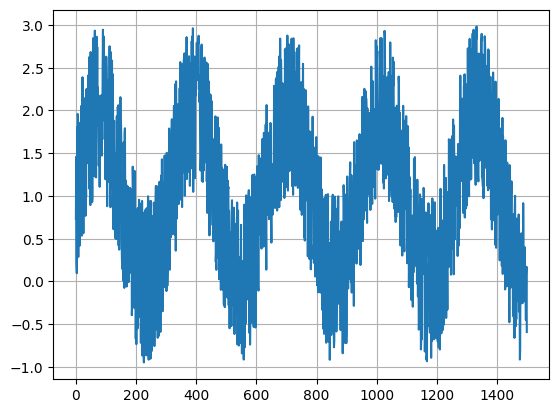

In [3]:
data = 1500
x = np.arange(data)
x = np.sin(0.02 * x) + np.random.rand(data) * 2

fig, ax = plt.subplots()
ax.plot(x)
ax.grid()

In [4]:
def convertToDataset(data, step):
    x, y = [], []
    for i in range(len(data) - step):
        x.append(data[i:i+step])
        y.append(data[i+step])
    return np.array(x, dtype='float32'), np.array(y, dtype='float32')

In [5]:
validation_split = int(0.8 * len(x))
x_train = x[:validation_split]
x_test = x[validation_split:]

x_train, y_train = convertToDataset(x_train, 10)
x_test, y_test = convertToDataset(x_test, 20)

In [6]:
model = keras.Sequential([
    GRU(64, input_shape=(None, 1), return_sequences=False),
    keras.layers.Dense(1)
])

model.compile(
    loss='mean_squared_error',
    optimizer='rmsprop'
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 64)                12672     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 12737 (49.75 KB)
Trainable params: 12737 (49.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [7]:
history = model.fit(
    x_train, y_train,
    batch_size=16,
    epochs=100,
    validation_data=(x_test, y_test)
)

Epoch 1/100
75/75 [==============================] - 2s 8ms/step - loss: 0.4191 - val_loss: 0.4127
Epoch 2/100
75/75 [==============================] - 0s 5ms/step - loss: 0.4131 - val_loss: 0.4484
Epoch 3/100
75/75 [==============================] - 0s 5ms/step - loss: 0.4046 - val_loss: 0.4250
Epoch 4/100
75/75 [==============================] - 0s 5ms/step - loss: 0.4057 - val_loss: 0.4338
Epoch 5/100
75/75 [==============================] - 0s 5ms/step - loss: 0.4042 - val_loss: 0.4695
Epoch 6/100
75/75 [==============================] - 0s 5ms/step - loss: 0.4014 - val_loss: 0.4241
Epoch 7/100
75/75 [==============================] - 0s 5ms/step - loss: 0.3990 - val_loss: 0.3829
Epoch 8/100
75/75 [==============================] - 0s 5ms/step - loss: 0.3997 - val_loss: 0.4749
Epoch 9/100
75/75 [==============================] - 0s 6ms/step - loss: 0.3989 - val_loss: 0.3949
Epoch 10/100
75/75 [==============================] - 0s 5ms/step - loss: 0.3967 - val_loss: 0.3849
Epoch 11/

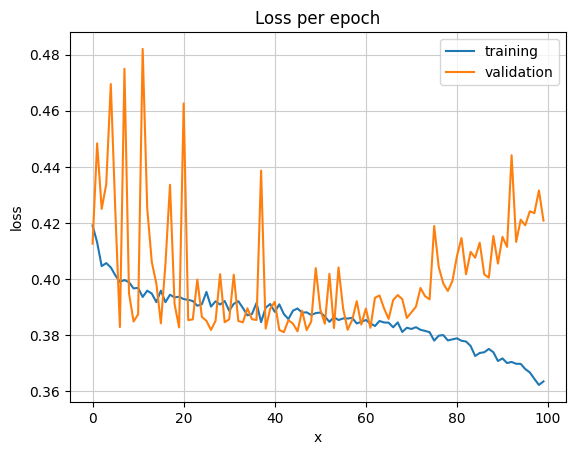

In [8]:
fig, ax = plt.subplots()
ax.plot(history.epoch, history.history['loss'], label='training')
ax.plot(history.epoch, history.history['val_loss'], label='validation')
ax.set_title('Loss per epoch')
ax.set_xlabel('x')
ax.set_ylabel('loss')
ax.grid(c='#ccc')
plt.legend()

9/9 [==============================] - 0s 3ms/step


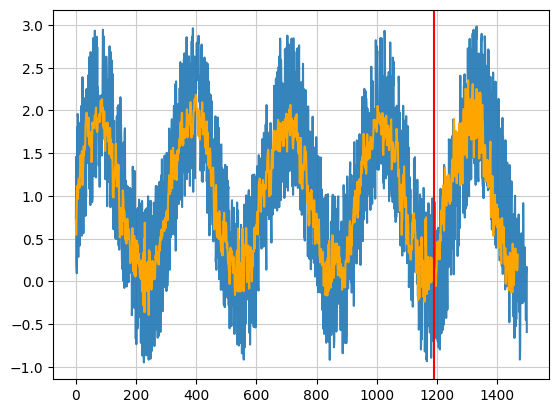

In [9]:
trainPredict = model.predict(x_train)
testPredict= model.predict(x_test)
predicted=np.concatenate((trainPredict,testPredict),axis=0)

plt.plot(x, alpha=0.9)
plt.plot(predicted, alpha=1, c='orange')
plt.axvline(len(x_train), c="r")
plt.grid(c='#ccc')
plt.show()